Code by </br>
* Ilya Mahrooghi 400110011
* Mahshad Moradi 400109373
* Mahyar Afshinmehr 400109735


# Library

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import math
import numpy.linalg as LA
import matplotlib.pyplot as plt
import random
import networkx as nx

In [2]:
%%capture
!pip install pygsp
from pygsp import graphs, plotting

# Model

In [15]:
def learn_graph(X, alpha, beta):
    train_X = np.copy(X)
    N = X.shape[1]
    P = X.shape[0]
    L = cp.Variable((P, P), PSD=True)
    identity = np.identity(P)

    constraints = []
    constraints.append(cp.trace(L) == P)
    constraints.append(cp.upper_tri(L) <= 0)
    constraints.append(L @ np.ones(P) == 0)

    X_copy = np.copy(X)
    objectives = np.zeros(20)
    for i in range(20):
        obj = cp.Minimize(
            alpha * (cp.trace(X.T @ (L @ X))) + beta * (cp.norm(L, "fro") ** 2)
        )
        prob = cp.Problem(obj, constraints)

        prob.solve(verbose=False, solver=cp.SCS, max_iters=10000)

        X = LA.inv(identity + (alpha * L.value)) @ X_copy
        objectives[i] = (
            LA.norm(X - X_copy, "fro") ** 2
            + alpha * (np.trace(X.T @ (L.value @ X)))
            + beta * (LA.norm(L.value, "fro") ** 2)
        )
        if i >= 1 and (np.abs(objectives[i] - objectives[i - 1]) < (10e-7)):
            print(f"FINISHED AT ITERATION: {i}")
            return L.value

    return np.zeros((P, P))

# Data

In [4]:
episodes = 200
total_nodes = 30
nodes = [i for i in range(total_nodes)]

def split_list(lst, k):
    random.shuffle(lst)
    split_size = len(lst) // k
    splits = [lst[i * split_size:(i + 1) * split_size] for i in range(k)]
    for i in range(len(lst) % k):
        splits[i].append(lst[-(i + 1)])
    return splits

splits = split_list(nodes, 5)
means = [20, 40, 10, 5, 25]
X = []
for i in range(episodes):
  row = [0] * total_nodes
  for group, num in zip(splits, range(len(splits))):
    for j in group:
      row[j] = means[num] + float(np.random.normal(0, 1, 1))
  X.append(row)
X = np.array(X).T

node_means = [0] * total_nodes
for group, num in zip(splits, range(len(splits))):
    for j in group:
      node_means[j] = means[num]

print(splits)
print(node_means)
print(X)

[[9, 16, 26, 8, 20, 14], [28, 1, 25, 6, 27, 13], [15, 10, 3, 7, 18, 0], [2, 22, 21, 24, 19, 5], [11, 4, 12, 23, 17, 29]]
[10, 40, 5, 10, 25, 5, 40, 10, 20, 20, 10, 25, 25, 40, 20, 10, 20, 25, 10, 5, 20, 5, 5, 25, 5, 40, 20, 40, 40, 25]
[[10.61420963 10.73779694  8.99188716 ... 11.10319697  8.63456548
   8.5100057 ]
 [40.68779071 40.07628113 40.3077588  ... 38.93053433 39.60529679
  39.74897914]
 [ 5.81895456  5.86024551  4.60543313 ...  4.60035575  4.8578788
   7.0656827 ]
 ...
 [40.87332542 40.42599514 39.0127854  ... 39.92807913 40.1911586
  39.85113036]
 [41.40050847 41.02045914 39.24105546 ... 40.55690932 41.05855856
  41.05903533]
 [24.37885361 23.77680389 25.78171591 ... 25.78172176 25.76277913
  25.29339071]]


# Train

In [16]:
learned_L = learn_graph(X,  0.0001, 0.01)

FINISHED AT ITERATION: 2


# Test and Visualization

In [17]:
mean_coordinates = [(0.2, 0.2), (0.2, 0.8), (0.8, 0.2), (0.5, 0.5), (0.8, 0.8)]
nodes_coordinates = [[0] * total_nodes, [0] * total_nodes]
for group, num in zip(splits, range(len(splits))):
  for i in group:
    nodes_coordinates[0][i] = mean_coordinates[num][0] + float(np.random.normal(0, 0.1, 1))
    nodes_coordinates[1][i] = mean_coordinates[num][1] + float(np.random.normal(0, 0.1, 1))
nodes_coordinates = np.array(nodes_coordinates)

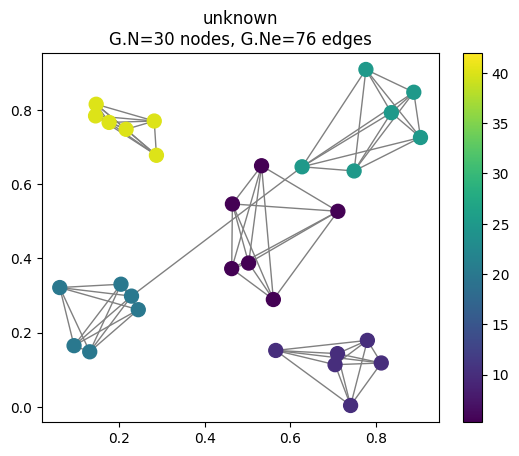

In [18]:
W = -learned_L
W[W<10e-7] = 0
np.fill_diagonal(W, 0)
G = graphs.Graph(W)
G.set_coordinates(nodes_coordinates.T)
plotting.plot_signal(G, np.array(node_means))

In [19]:
def convert_pygsp_to_networkx(pygsp_graph):
    nx_graph = nx.Graph()

    nx_graph.add_nodes_from(range(pygsp_graph.N))

    edges = pygsp_graph.get_edge_list()
    edges = [list(lst) for lst in edges]
    for n1, n2 in zip(edges[0], edges[1]):
      nx_graph.add_edge(n1, n2)

    return nx_graph

In [20]:
nx_G = convert_pygsp_to_networkx(G)

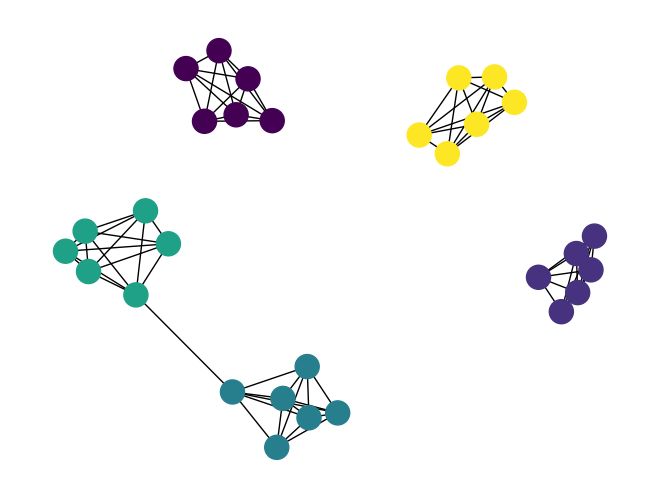

In [23]:
nx.draw(nx_G, nx.spring_layout(nx_G, k=0.65), node_color=node_means)